In [1]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import quilt
from quilt.data.elijahc import ripc

from sklearn.manifold import TSNE,Isomap

import bokeh.plotting as bp
from bokeh.models import ColumnDataSource, Span

In [2]:
pop_df = ripc.untargeted.log2fc_plasma_agg_stats()
pop_df = pop_df.dropna()
pop_df.tail()

,min,Molecular_Weight,log2fc_mean,log2fc_var,p-value
726485,60,268.20519,0.094736,0.812804,0.569362
726486,60,190.17731,-0.092935,0.587453,0.511858
726487,60,150.14178,-0.099776,1.926829,0.696683
726488,60,568.38420,-0.024295,0.092641,0.665231
726489,60,268.20540,-0.367258,0.681297,0.021178


## Extract compounds that have statistically significant p-values at all timepoints after 10min

In [3]:
timepoint_dfs = []
for t in [2,4,6,8,10]:
    t_df = pop_df.query("min == {}".format(t))
    timepoint_dfs.append(t_df[t_df['p-value'] <= 0.01])
tp_mol_w_dfs = [np.unique(df['Molecular_Weight'].values) for df in timepoint_dfs]

In [4]:
tp_mol_w_dfs[-1]

array([  66.98955,   67.98707,   67.98743, ..., 1769.6622 , 1958.79067,
       2040.82265])

In [5]:
# Keep only compounts that appear in all 5 timepoints
u_idx = tp_mol_w_dfs[0]
for arr in tp_mol_w_dfs[1:]:
    u_idx = np.intersect1d(u_idx,arr)
print(len(u_idx))

2533


In [6]:
def set_filter(df,column,criteria):
    return df[df[column].isin(criteria)]

In [7]:
pop_df_short = set_filter(pop_df,'Molecular_Weight',u_idx)

In [8]:
comp_ts_profile = pop_df_short.pivot_table(columns='min',index='Molecular_Weight',values='log2fc_mean')

In [9]:
X = comp_ts_profile.values

In [10]:
X_embedded = TSNE(n_components=2,verbose=1,n_iter=5000).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2533 samples in 0.015s...
[t-SNE] Computed neighbors for 2533 samples in 0.146s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2533
[t-SNE] Computed conditional probabilities for sample 2000 / 2533
[t-SNE] Computed conditional probabilities for sample 2533 / 2533
[t-SNE] Mean sigma: 0.063966
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.655647
[t-SNE] Error after 5000 iterations: 1.152107


In [11]:
tsne_df = pd.DataFrame(X_embedded,index=comp_ts_profile.index,columns=['dim_1','dim_2']).reset_index()
tsne_df.head(2)

,Molecular_Weight,dim_1,dim_2
0,67.98743,-36.205143,14.735681
1,68.06219,-27.303459,16.370192


In [41]:
X_embedded = Isomap(n_neighbors=6,n_components=2).fit_transform(X)

In [59]:
isomap_df = pd.DataFrame(X_embedded,index=comp_ts_profile.index,columns=['dim_1','dim_2']).reset_index()
isomap_df.head(2)

,Molecular_Weight,dim_1,dim_2
0,67.98743,0.565927,0.024607
1,68.06219,0.655651,0.234022


In [60]:
len(isomap_df)

2533

In [44]:
from bokeh.palettes import Plasma256
from bokeh.transform import log_cmap
from bokeh.models import LassoSelectTool

mapper = log_cmap(field_name='Molecular_Weight', palette=Plasma256 ,low=min(isomap_df['Molecular_Weight'].values) ,high=max(isomap_df['Molecular_Weight'].values))

def plot_cluster(x,y,hue=None,data=None,tools='hover,save,reset,pan,lasso_select,wheel_zoom',**kwargs):
    X_vals = data[x]
    Y_vals = data[y]
    source = ColumnDataSource(data)
    p = bp.figure(tools=tools, x_range=(min(X_vals),max(X_vals)), y_range=(min(Y_vals),max(Y_vals)))
    p.hover.tooltips = [
        ("Molecular Weight", "@{Molecular_Weight}"),
        ("dim_1", "@dim_1"),
        ("dim_2", "@dim_2")
    ]
    p.circle(x,y, line_color=hue, color=hue, size=5,source=source)
    
    return p


In [45]:
bp.output_notebook()
p = plot_cluster('dim_1','dim_2',hue=mapper,data=isomap_df)
bp.show(p)

Loading BokehJS ...

In [61]:
cluster1 = isomap_df.query('dim_2 >= 2')
cluster1['cluster_id'] = 0

cluster2 = isomap_df.query('dim_2 <= -3')
cluster2['cluster_id'] = 1

cluster3 = isomap_df.query('dim_1 > 2')
cluster3['cluster_id'] = 2

cluster4 = isomap_df.query('dim_1 <= 2 & dim_1 >= -2 & dim_2 >= -2 & dim_2 <= 2')
cluster4['cluster_id'] = 3

cluster5 = isomap_df.query('dim_1 < -2')
cluster5['cluster_id'] = 4



clust_df = pd.concat([cluster1,cluster2,cluster3,cluster4,cluster5])
isomap_df = isomap_df.merge(clust_df.set_index('Molecular_Weight')[['cluster_id']],on='Molecular_Weight',how='left')

/home/elijahc/.pyenv/versions/jupyterlab-gpu/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/elijahc/.pyenv/versions/jupyterlab-gpu/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/elijahc/.pyenv/versions/jupyterlab-gpu/lib/python3.5/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

In [62]:
isomap_df.head()

,Molecular_Weight,dim_1,dim_2,cluster_id
0,67.98743,0.565927,0.024607,3
1,68.06219,0.655651,0.234022,3
2,68.06391,4.078675,-1.342234,2
3,69.06730,2.936165,-0.791508,2
4,70.04333,-1.098815,0.008882,3


In [63]:
subset = isomap_df['Molecular_Weight'].values
isomap_merge_df = pop_df[pop_df['Molecular_Weight'].isin(subset)].merge(isomap_df,on='Molecular_Weight')
# tsne_merge_df = pop_df[pop_df['Molecular_Weight'].isin(subset)].merge(tsne_df,on='Molecular_Weight') 

In [64]:
clust_df.groupby(['cluster_id']).count()

,Molecular_Weight,dim_1,dim_2
cluster_id,,,
0,3,3,3
1,10,10,10
2,13,13,13
3,2343,2343,2343
4,165,165,165


In [65]:
clust_df.to_csv('../data/isomap_early_0.01_clusters.csv',index=False)

In [66]:
isomap_merge_df.head()

,min,Molecular_Weight,log2fc_mean,log2fc_var,p-value,dim_1,dim_2,cluster_id
0,2,449.31591,-0.241909,0.148228,0.001778,-3.0771,-0.514857,4
1,4,449.31591,-0.323831,0.276860,0.002136,-3.0771,-0.514857,4
2,6,449.31591,-0.268653,0.148763,0.000660,-3.0771,-0.514857,4
3,8,449.31591,-0.332641,0.268869,0.001471,-3.0771,-0.514857,4
4,10,449.31591,-0.322770,0.199592,0.000449,-3.0771,-0.514857,4


In [67]:
isomap_merge_df.to_csv('../data/isomap_early_0.01.csv',index=False)
# tsne_merge_df.to_csv('../data/tsne_early_0.01.csv',index=False)

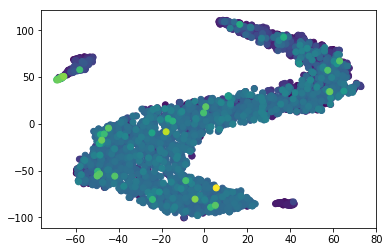

In [16]:
plt.scatter(X_embedded[:,0],X_embedded[:,1],c=comp_ts_profile.index.values)